<a href="https://colab.research.google.com/github/kgudalewski/trading/blob/main/trading_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TODO
# + funkcja przygotowująca dane do imitacji grania (dodanie kolumn na sygnały open short, close short, open long, close long)
# + imitacja funkcji create order dla long i dla short
# + imitacja funkcji close order
# dodać stop loss i take profit do strategi
# dodać klase mt5 , zeby kod ze strategi wyglądał tak samo

# przygotowanie danych do backtestingu (dodanie kolumny z saldem)

In [13]:
real_trade = False

# Set up

In [28]:
# set up
if real_trade:
  import MetaTrader5 as mt5
  from datetime import datetime
  import time
  import pandas as pd
elif not real_trade:
  from datetime import datetime, timedelta
  import time
  import pandas as pd
  from google.colab import drive
  # drive.mount('/content/drive')
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import StandardScaler

# Functions

In [7]:
# MT5 connection init function
if real_trade:
  def initialize_mt5(login, password, server):

      if not mt5.initialize(login=login, password=password, server=server):
          print(f"Nie można połączyć się z MetaTrader 5, błąd: {mt5.last_error()}")
          return False
      print("Połączono z MetaTrader 5")

  # if doesn't work
  # mt5.initialize()
  # mt5.login(login, password, server)

In [8]:
# order send func

if real_trade:

  def create_order(order_type, idx=None, ticker=None, qty=None, sl_pct=None , tp_pct=None):

    if order_type == "BUY":
      order_type = mt5.ORDER_TYPE_BUY
      price = mt5.symbol_info_tick(ticker).ask
      sl = price * (1  - sl_pct)
      tp = price * (1 + tp_pct)
    elif order_type == "SELL":
      order_type = mt5.ORDER_TYPE_SELL
      price = mt5.symbol_info_tick(ticker).bid
      sl = price * (1  + sl_pct)
      tp = price * (1 - tp_pct)

    request = {
      "action": mt5.TRADE_ACTION_DEAL,
      "symbol": ticker,
      "volume": qty,
      "type": order_type,
      "price": price,
      "sl": sl, # FLOAT
      "tp": tp, # FLOAT,
      "comment": "Python open position",
      "type_time": mt5.ORDER_TIME_GTC,
      "type_filling": mt5.ORDER_FILLING_IOC,
    }

    order = mt5.order_send(request)
    return order

elif not real_trade:

  def create_order(order_type, idx=None, ticker=None, qty=None, sl=None , tp=None):
    if order_type == "BUY": # to znaczy otwarcie longa
      df.loc[idx,"open_long"] = 1 # w ostatnim wierszu , kolumnie open_long sygnalizuje otwarcie longa "1"ką
    if order_type == "SELL": # to znaczy otwarcie shorta
      df.loc[idx,"open_short"] = 1 # w ostatnim wierszu , kolumnie open_short sygnalizuje otwarcie shorta "1"ką

In [9]:
#order close func

if real_trade:

  def close_order(order_type, idx=None, ticker=None, qty=None):

    if order_type == "BUY":
      order_type = mt5.ORDER_TYPE_BUY
      price = mt5.symbol_info_tick(ticker).ask
    elif order_type == "SELL":
      order_type = mt5.ORDER_TYPE_SELL
      price = mt5.symbol_info_tick(ticker).bid

    request = {
      "action": mt5.TRADE_ACTION_DEAL,
      "symbol": ticker,
      "volume": qty,
      "type": order_type,
      "position": mt5.positions_get()[0]._asdict()['ticket'],
      "price": price,
      "comment": "Close position",
      "type_time": mt5.ORDER_TIME_GTC,
      "type_filling": mt5.ORDER_FILLING_IOC,
    }
    order = mt5.order_send(request)
    return order

elif not real_trade:

  def close_order(order_type, idx=None, ticker=None, qty=None, price=None, sl=None , tp=None):
    if order_type == "BUY": # zamkniecie shorta poprzez wykupienie go
      df.loc[idx,"close_short"] = 1 # w ostatnim wierszu , kolumnie close_short sygnalizuje zamkniecie shorta "1"ką (poprzez wykupienie go)
    if order_type == "SELL": # zamkniecie longa poprzez sprzedanie go
      df.loc[idx,"close_long"] = 1 # w ostatnim wierszu , kolumnie close_long sygnalizuje zamkniecie longa "1"ką (poprzez sprzedanie go)

In [10]:
# preparing df for imitation

if not real_trade:

  def prepare_for_imitation(df):

    df["open_short"] = 0
    df["close_short"] = 0
    df["open_long"] = 0
    df["close_long"] = 0
    return df

# Introduction to strategy

In [ ]:
if real_trade:
  login = 1520661470
  password = "@6$Ejp!k"
  server = "FTMO-Demo2"

  initialize_mt5(login, password, server)

Połączono z MetaTrader 5


True

In [ ]:
# basic info

# ticker = "TSLA"
# interval = mt5.TIMEFRAME_D1
# from_date = datetime.now()
# no_of_rows = 100
# rates = mt5.copy_rates_from(ticker, interval, from_date, no_of_rows)
# account_info = mt5.account_info()
# account_info.balance
# account_info.login
# num_symbols = mt5.symbols_total()
# symbol_info = mt5.symbols_get()
# mt5.symbol_info(ticker)._asdict()

In [33]:
if real_trade:
  df = pd.read_csv("/content/drive/MyDrive/TSLA_M30_01_2021-11_2024.csv", index_col=0)
  df = prepare_for_imitation(df)
  df.head()

# Strategy

In [ ]:
ohlc = pd.DataFrame(mt5.copy_rates_range(ticker, mt5.TIMEFRAME_M1, datetime.now() - timedelta(days=7), datetime.now()))
ohlc

,time,open,high,low,close,tick_volume,spread,real_volume
0,1738600500,385.39,386.95,384.69,386.82,189,15,0
1,1738600560,386.82,387.87,385.51,386.41,159,13,0
2,1738600620,386.31,386.34,385.19,386.25,153,13,0
3,1738600680,386.23,386.23,383.60,384.94,168,9,0
4,1738600740,384.94,386.05,384.09,385.52,155,16,0
...,...,...,...,...,...,...,...,...
380,1738623300,383.54,384.34,383.46,384.01,176,4,0
381,1738623360,383.93,383.95,383.00,383.63,187,5,0
382,1738623420,383.61,384.23,383.56,384.12,160,7,0
383,1738623480,384.08,384.31,383.72,384.31,161,6,0


In [ ]:
[(position._asdict()['ticket'],position._asdict()['symbol']) for position in list(mt5.positions_get())]

[(63208821, 'NVDA'),
 (63208929, 'NVDA'),
 (63208931, 'NVDA'),
 (63208938, 'NVDA'),
 (63208939, 'NVDA'),
 (63208940, 'NVDA'),
 (63208943, 'NVDA'),
 (63208946, 'NVDA'),
 (63208948, 'NVDA'),
 (63208950, 'NVDA')]

In [ ]:
# df = prepare_for_imitation(pd.read_csv("/content/drive/MyDrive/TSLA_M30_01_2021-11_2024.csv", index_col=0))

# already_buy = False
# already_sell = False
# no_position = True
for i in range(600):
# for i in range(3,df.shape[0]):
  # dla real trade
  df = pd.DataFrame(mt5.copy_rates_range(ticker,mt5.TIMEFRAME_M1, datetime.now() - timedelta(days=7), datetime.now()))
  df['time'] = pd.to_datetime(df['time'], unit = 's')
  # print(ohlc)

  # dla real trade
  # current_close = df.iloc[-1]["close"] # cena zamknięcia z ostatniego wiersza
  # last_close = df.iloc[-2]["close"] # cena zamknięcia z przed ostatniego wiersza
  # last_high = df.iloc[-2]["high"] # high z przed ostatniego wiersza
  # last_low = df.iloc[-2]["low"] # low z przed ostatniego wiersza

# ---------------------------------------------------------------------
# strategia
# tylko ten kawałek kodu trzeba będzie edytować , żeby output long_condition, short_condition itp były na podstawie innych warunków


  current_close = df.iloc[i]["close"]
  last_close = df.iloc[i-1]["close"]
  last_high = df.iloc[i-1]["high"]
  last_low = df.iloc[i-1]["low"]
  # strategy
  long_condition = current_close > last_high
  short_condition = current_close < last_low
  closelong_condition = current_close < last_close
  closeshort_condition = current_close > last_close


# ---------------------------------------------------------------------

  # dla real trade
  already_buy = False
  already_sell = False
  try:
    already_sell = mt5.positions_get()[0]._asdict['type'] == 1
    already_buy = mt5.positions_get()[0]._asdict['type'] == 0
  except:
    pass

  # dla real trade
  no_position = len(mt5.positions_get()) == 0

  if long_condition:
    if no_position:
      # dla real trade
      create_order(ticker, qty, buy_order_type, mt5.symbol_info_tick(ticker).ask, mt5.symbol_info_tick(ticker).ask * (1 - .05) , mt5.symbol_info_tick(ticker).ask * (1 + .1))
      print("Buy order placed, due to long_condition")
      # create_order(i,"BUY")
      # long_buy_price = df.iloc[i]['close']
      # no_position = False
      # already_buy = True
    if already_sell:
      # dla real trade
      close_order(ticker, qty, buy_order_type, mt5.symbol_info_tick(ticker).ask)
      print("Sell position closed, due to long_condition")
      time.sleep(1)
      create_order(ticker, qty, buy_order_type, mt5.symbol_info_tick(ticker).ask, mt5.symbol_info_tick(ticker).ask * (1 - .05) , mt5.symbol_info_tick(ticker).ask * (1 + .1))
      print("Buy order placed, due to long_condition")
      # close_order(i, "BUY")
      # no_position = True
      # already_sell = False
      # create_order(i, "BUY")
      # long_buy_price = df.iloc[i]['close']
      # no_position = False
      # already_buy = True
  if short_condition:
    if no_position:
      # dla real trade
      create_order(ticker, qty, sell_order_type, mt5.symbol_info_tick(ticker).bid, mt5.symbol_info_tick(ticker).bid * (1 + .05) , mt5.symbol_info_tick(ticker).bid * (1 - .1))
      print("Sell order placed, due to short_condition")
      # create_order(i,"SELL")
      # short_sell_price = df.iloc[i]['close']
      # no_position = False
      # already_sell = True
    if already_buy:
      # dla real trade
      close_order(ticker, qty, sell_order_type, mt5.symbol_info_tick(ticker).bid)
      print("Buy position closed, due to short_condition")
      time.sleep(1)
      create_order(ticker, qty, sell_order_type, mt5.symbol_info_tick(ticker).bid, mt5.symbol_info_tick(ticker).bid * (1 + .05) , mt5.symbol_info_tick(ticker).bid * (1 - .1))
      print("Sell order placed, due to short_condition")
      # close_order(i, "SELL")
      # no_position = True
      # already_buy = False
      # create_order(i, "SELL")
      # short_sell_price = df.iloc[i]['close']
      # no_position = False
      # already_sell = True

  # if already_buy:
  #   long_sell_price = df.iloc[i]['close']
  #   if long_sell_price/long_buy_price > 1.2 or long_sell_price/long_buy_price < 0.95 : # take profit i stop loss dla longa
  #     close_order(i, "SELL")
  #     already_buy = False
  #     no_position = True

  # if already_sell:
  #   short_buy_price = df.iloc[i]['close']
  #   if short_sell_price/short_buy_price > 1.2 or short_sell_price/short_buy_price < 0.95 : # take profit i stop loss dla shorta
  #     close_order(i, "BUY")
  #     already_sell = False
  #     no_position = True

  # dla real trade
  try:
    already_sell = mt5.positions_get()[0]._asdict['type'] == 1
    already_buy = mt5.positions_get()[0]._asdict['type'] == 0
  except:
    pass

  # dla real trade
  if closelong_condition and already_buy:
      close_order(ticker, qty, sell_order_type, mt5.symbol_info_tick(ticker).bid)
      print("Only buy position closed")
  if closeshort_condition and already_sell:
      close_order(ticker, qty, buy_order_type, mt5.symbol_info_tick(ticker).ask)
      print("Only sell position closed")

  if closelong_condition and already_buy:
      # dla real trade
      close_order(ticker, qty, sell_order_type, mt5.symbol_info_tick(ticker).bid)
      print("Only buy position closed")
      # close_order(i, "SELL")
      # already_buy = False
      # no_position = True
  if closeshort_condition and already_sell:
      # dla real trade
      close_order(ticker, qty, buy_order_type, mt5.symbol_info_tick(ticker).ask)
      print("Only sell position closed")
      # close_order(i, "BUY")
      # already_sell = False
      # no_position = True

  # dla real trade
  already_buy = False
  already_sell = False
  time.sleep(60)



Buy order placed, due to long_condition
Buy order placed, due to long_condition


In [ ]:
create_order(ticker=ticker, qty=qty, order_type=buy_order_type, price=mt5.symbol_info_tick(ticker).ask, sl=mt5.symbol_info_tick(ticker).ask * (1 - .05) , tp=mt5.symbol_info_tick(ticker).ask * (1 + .1))

OrderSendResult(retcode=10009, deal=0, order=63257497, volume=1.0, price=0.0, bid=0.0, ask=0.0, comment='Request executed', request_id=1022785705, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='EURUSD', volume=1.0, price=1.03746, stoplimit=0.0, sl=0.985587, tp=1.1412060000000002, deviation=0, type=0, type_filling=1, type_time=0, expiration=0, comment='Python open position', position=0, position_by=0))

In [ ]:
close_order(ticker=ticker, qty=qty, order_type=sell_order_type, price=mt5.symbol_info_tick(ticker).ask)

OrderSendResult(retcode=10009, deal=0, order=63257791, volume=1.0, price=0.0, bid=0.0, ask=0.0, comment='Request executed', request_id=1022785707, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='EURUSD', volume=1.0, price=1.03749, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=1, type_filling=1, type_time=0, expiration=0, comment='Close position', position=63257497, position_by=0))

In [ ]:
df["profit"] = 1
total_prcnt = 1

for i in range(3,df.shape[0]):
  if df.iloc[i]["open_short"] == 1:
    sell_p_short = df.iloc[i]["close"]
  if df.iloc[i]["open_long"] == 1:
    buy_p_long = df.iloc[i]["close"]
  if df.iloc[i]["close_short"] == 1:
    buy_p_short = df.iloc[i]["close"]
  if df.iloc[i]["close_long"] == 1:
    sell_p_long = df.iloc[i]["close"]
  if df.iloc[i]["close_short"] == 1:
    profit = ((sell_p_short - buy_p_short)/buy_p_short) * 100
    print(f"Short position ended with profit {profit} % on index {i}")
    total_prcnt = total_prcnt + (total_prcnt * (profit/100))
    # df['profit'][i] = total_prcnt
  if df.iloc[i]["close_long"] == 1:
    profit = ((sell_p_long - buy_p_long)/buy_p_long) * 100
    print(f"Long position ended with profit {profit} % on index {i}")
    total_prcnt = total_prcnt + (total_prcnt * (profit/100))
    # df['profit'][i] = total_prcnt
  df['profit'][i] = total_prcnt


In [ ]:
df_profits = df.loc[df.profit != 1].copy()
df_profits.head()

,time,open,high,low,close,tick_volume,spread,real_volume,open_short,close_short,open_long,close_long,profit
9,2021-01-05 18:30:00,246.08,246.90,244.46,245.83,6904,0,0,0,0,0,1,0.998984
10,2021-01-05 19:30:00,245.84,246.75,245.06,246.24,5919,0,0,0,0,0,0,0.998984
11,2021-01-05 20:30:00,246.23,246.83,245.65,246.06,6129,0,0,0,0,0,0,0.998984
12,2021-01-05 21:30:00,246.07,246.42,244.50,245.25,6700,0,0,1,0,0,0,0.998984
13,2021-01-05 22:30:00,245.25,245.57,243.69,245.07,3923,0,0,0,0,0,0,0.998984


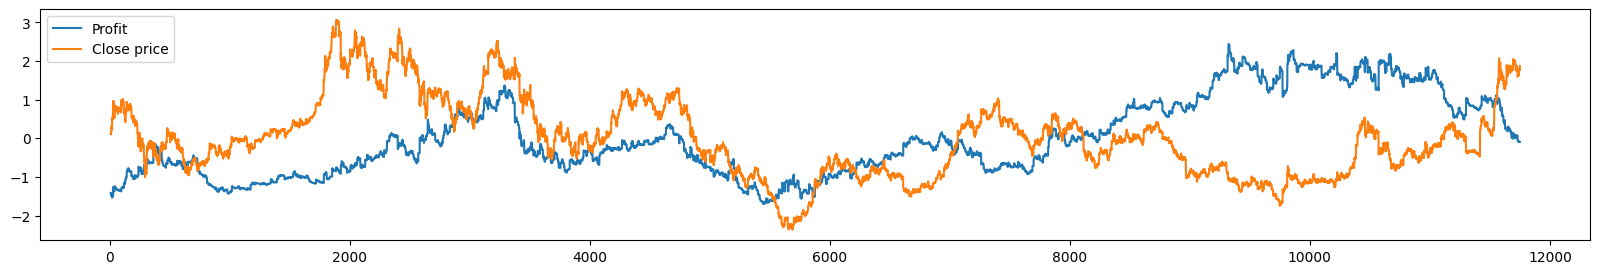

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_profits.index,StandardScaler().fit_transform(pd.DataFrame(df_profits["profit"])), label="Profit")
plt.plot(df_profits.index, StandardScaler().fit_transform(pd.DataFrame(df_profits["close"])), label="Close price")
# plt.axhline(1)
plt.legend()
plt.show()

In [ ]:
StandardScaler().fit_transform(pd.DataFrame(df_profits["profit"]))
# pd.DataFrame(df_profits["profit"])

array([[-1.41436743],
       [-1.41436743],
       [-1.41436743],
       ...,
       [-0.08785726],
       [-0.09825806],
       [-0.09825806]])

In [ ]:
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume,open_short,close_short,open_long,close_long,profit
11745,2024-11-29 17:30:00,340.74,341.26,338.90,339.25,5294,3,0,0,0,0,1,1.465482
11746,2024-11-29 18:00:00,339.27,339.96,337.70,339.13,4924,3,0,0,0,0,0,1.465482
11747,2024-11-29 18:30:00,339.12,341.22,338.58,340.56,5045,3,0,0,0,1,0,1.465482
11748,2024-11-29 19:00:00,340.58,340.88,339.25,339.71,4752,4,0,0,0,0,1,1.461824
11749,2024-11-29 19:30:00,339.72,345.22,339.50,345.12,5779,3,0,0,0,1,0,1.461824


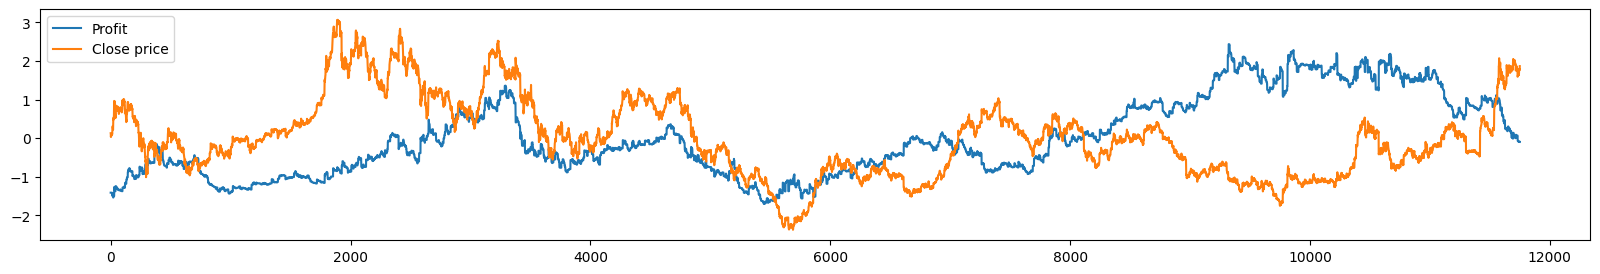

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df.index,StandardScaler().fit_transform(pd.DataFrame(df["profit"])), label="Profit")
plt.plot(df.index, StandardScaler().fit_transform(pd.DataFrame(df["close"])), label="Close price")
# plt.axhline(1)
plt.legend()
plt.show()